# Rough Notebook to be changed to pct reduction
## Last Updated: 10-30-2020

In [1]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import json
import warnings
from os import listdir
from os.path import isfile,join
import datetime
import requests
from sklearn.metrics import r2_score, accuracy_score
import catboost
import matplotlib as mpl
import sys
sys.path.append('.')
from src.utils import collect_data
from src.utils import eda
import warnings
warnings.filterwarnings('ignore')

In [2]:
import importlib
importlib.reload(collect_data)
collect_datasets = collect_data.DataCollection()
data_analysis = eda.DataAnalysis()

In [3]:
df_mobility = collect_datasets.get_mobility_data(download=False)
df_county_spending = collect_datasets.get_spend_data()
df_covid = collect_datasets.combine_covid_data()
df_weather = collect_datasets.combine_weather(df_mobility,df_covid)
df_county = collect_datasets.combined_county_data()

In [6]:
def get_combined_df(df_weather, df_mob,df_covid,df_demographics,year=2019):
    df_mob = df_mob.dropna()
    thr_date = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
    covid_date = '2020-03-15'
    if year==2020:
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=thr_date]
    elif year =='covid':
        df_mob_prep = pd.merge(left = df_mob, right = df_covid, on = ['fips', 'date'], how='inner')
        df_mob_prep = df_mob_prep[df_mob_prep.date >=covid_date]
    else:
        df_mob_prep = df_mob[(df_mob.date < thr_date)]
        
    df_mob_weather = pd.merge(left = df_mob_prep, right = df_weather, on =['date', 'fips'])

    return df_mob_weather

In [7]:
df_2019_mob = get_combined_df(df_weather, df_mobility, df_covid, df_demographics=df_county)
df_covid_mob = get_combined_df(df_weather, df_mobility, df_covid, df_demographics=df_county,year = 'covid')


In [8]:
def create_pct_change_df(month, df_covid,df_2019,target_cols):
    df_covid_month = df_covid[df_covid['month'] == month]
    df_2019_month = df_2019[df_2019['month'] == month]

    df_covid_fips_gr_month = df_covid_month.groupby(['fips'])[target_cols].mean().reset_index()
    df_2019_fil_gr_month = df_2019_month.groupby(['fips'])[target_cols].mean().reset_index()
    df_covid_pct_changes_month = df_covid_fips_gr_month.join(df_2019_fil_gr_month.set_index('fips'),on='fips',
                                                      lsuffix='_covid',rsuffix='_2019',how='inner')
    for col in target_cols:
        df_covid_pct_changes_month[month +'_pct_change_'+col] = (df_covid_pct_changes_month[col+'_2019'] \
                                                         - df_covid_pct_changes_month[col+'_covid'])*100\
                                                        / (df_covid_pct_changes_month[col+'_2019'])
        df_covid_pct_changes_month = df_covid_pct_changes_month.drop(columns = [col+'_covid', col+'_2019'])
    
    return df_covid_pct_changes_month

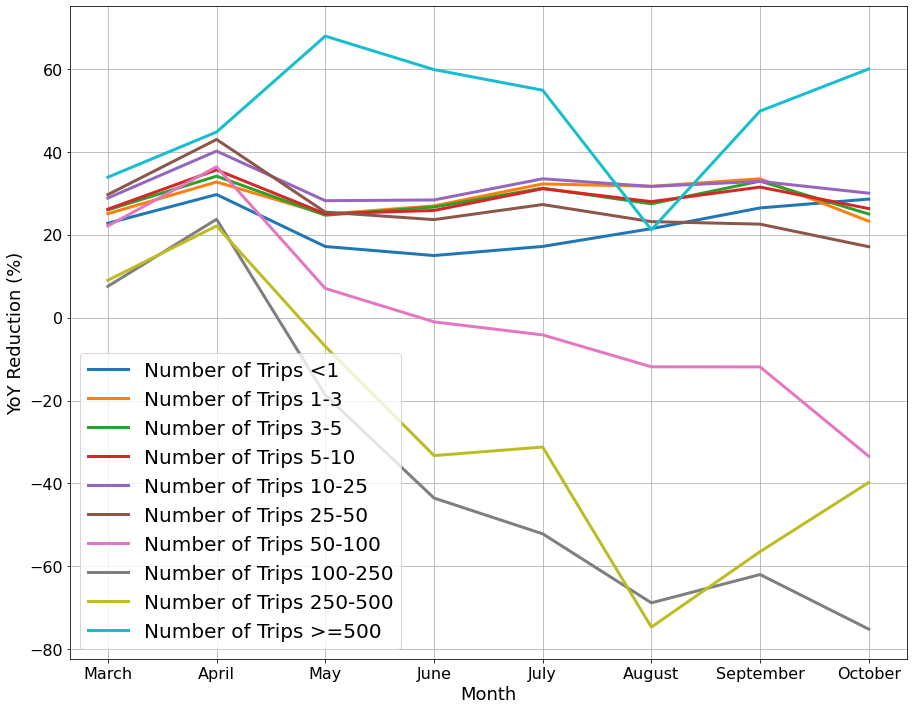

In [9]:
months = ['March', "April", 'May','June','July','August','September','October']
target_cols = [col for col in df_mobility.columns if 'Number' in col][1:]
df_pct_change = pd.DataFrame()
df_pct_change['fips'] = df_mobility['fips'].unique()
for month in months:

    df_pct_change_month  = create_pct_change_df(month, df_covid_mob,df_2019_mob,target_cols=target_cols)
    df_pct_change = df_pct_change.join(df_pct_change_month.set_index('fips'),on='fips')
    df_pct_change = df_pct_change.dropna()
plt.figure(figsize=(15,12))
for col in target_cols:
    cols = [c for c in df_pct_change.columns if col in c]
    df_pct_change['Mean_Reduction_in_'+col] = df_pct_change[cols].sum(axis=1)/len(months)
    #df_pct_change = df_pct_change.drop(columns=cols)
    plt.plot(months,df_pct_change[cols].median(axis=0).values,label=col,lw=3)
plt.legend(fontsize=20)
plt.ylabel('YoY Reduction (%)', fontsize =18)
plt.xlabel('Month', fontsize =18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.show()

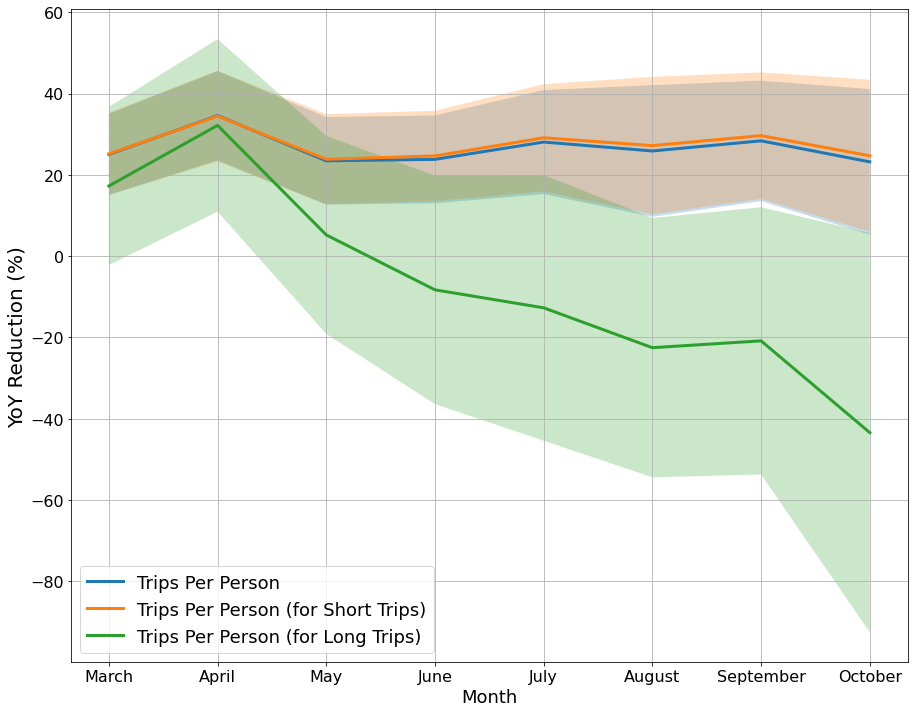

In [10]:
months = ['March', "April", 'May','June','July','August','September','October']
target_cols = ['trips_per_person','trips_per_person_short','trips_per_person_long']
# df_pct_change = pd.DataFrame()
# df_pct_change['fips'] = df_mobility['fips'].unique()
plt.figure(figsize=(15,12))
for month in months:

    df_pct_change_month  = create_pct_change_df(month, df_covid_mob,df_2019_mob,target_cols=target_cols)
    df_pct_change = df_pct_change.join(df_pct_change_month.set_index('fips'),on='fips')
    df_pct_change = df_pct_change.dropna()
for col in target_cols:
    if 'short' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'short' in c]
    elif 'long' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'long' in c]
    else:
        cols = [c for c in df_pct_change.columns if col in c and 'short' not in c and 'long' not in c]
#     cols = [c for c in df_pct_change.columns if col in c]
    df_pct_change['Mean_Reduction_in_'+col] = df_pct_change[cols].sum(axis=1)/len(months)
    mean = df_pct_change[cols].mean(axis=0).values
    std = df_pct_change[cols].std(axis=0).values
    plt.plot(months,mean,lw=3)
    plt.fill_between(months,mean-std,mean+std,alpha=0.25)
labels = ['Trips Per Person','Trips Per Person (for Short Trips)','Trips Per Person (for Long Trips)']

plt.legend(labels,fontsize=18,loc='lower left')
plt.ylabel('YoY Reduction (%)', fontsize =20)
plt.xlabel('Month', fontsize =18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(-20,50)

plt.grid()
plt.show()
# df_pct_change

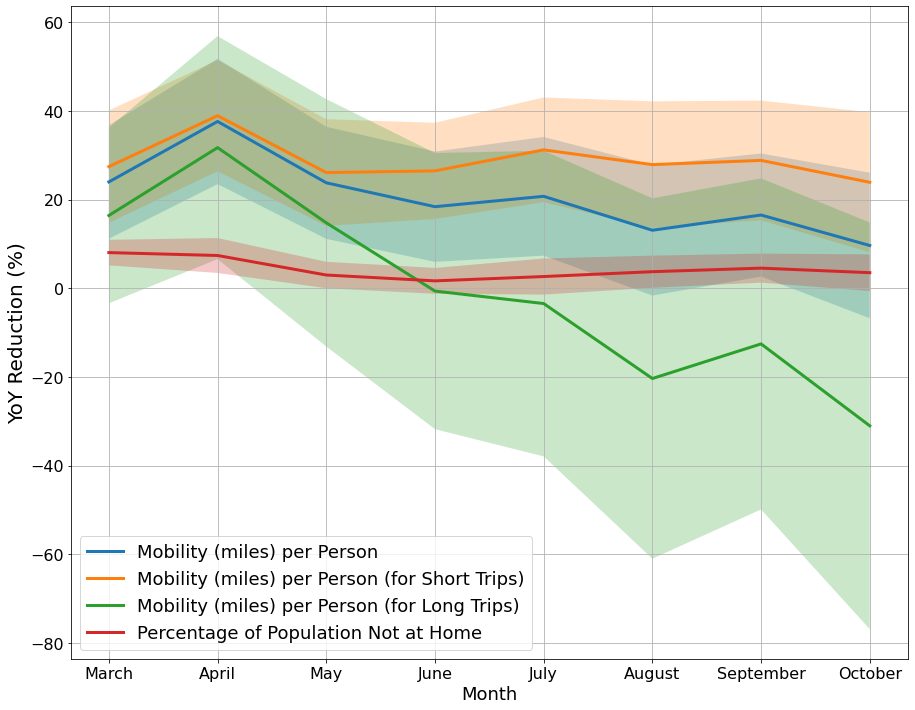

In [11]:
months = ['March', "April", 'May','June','July','August','September','October']
target_cols = ['mobility_per_person','mobility_per_person_short','mobility_per_person_long','pct_not_home']
# df_pct_change = pd.DataFrame()
# df_pct_change['fips'] = df_mobility['fips'].unique()
plt.figure(figsize=(15,12))
for month in months:

    df_pct_change_month  = create_pct_change_df(month, df_covid_mob,df_2019_mob,target_cols=target_cols)
    df_pct_change = df_pct_change.join(df_pct_change_month.set_index('fips'),on='fips')
    df_pct_change = df_pct_change.dropna()
for col in target_cols:
    if 'short' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'short' in c]
    elif 'long' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'long' in c]
    else:
        cols = [c for c in df_pct_change.columns if col in c and 'short' not in c and 'long' not in c]
#     cols = [c for c in df_pct_change.columns if col in c]
    df_pct_change['Mean_Reduction_in_'+col] = df_pct_change[cols].sum(axis=1)/len(months)
    mean = df_pct_change[cols].mean(axis=0).values
    std = df_pct_change[cols].std(axis=0).values
    plt.plot(months,mean,lw=3)
    plt.fill_between(months,mean-std,mean+std,alpha=0.25)
labels = [ 'Mobility (miles) per Person',"Mobility (miles) per Person (for Short Trips)", 
          'Mobility (miles) per Person (for Long Trips)', 'Percentage of Population Not at Home']

plt.legend(labels,fontsize=18,loc='lower left')

plt.ylabel('YoY Reduction (%)', fontsize =20)
plt.xlabel('Month', fontsize =18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(-20,50)

plt.grid()
plt.show()
# df_pct_change

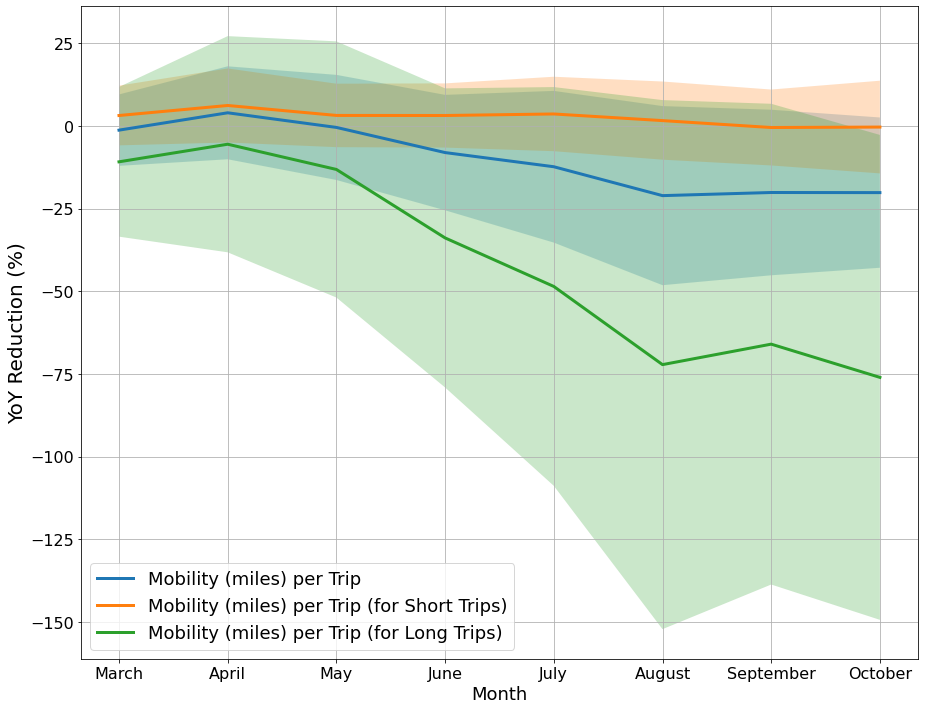

In [12]:
months = ['March', "April", 'May','June','July','August','September','October']
target_cols = ['mobility_per_trip','mobility_per_trip_short','mobility_per_trip_long']
# df_pct_change = pd.DataFrame()
# df_pct_change['fips'] = df_mobility['fips'].unique()
plt.figure(figsize=(15,12))
for month in months:

    df_pct_change_month  = create_pct_change_df(month, df_covid_mob,df_2019_mob,target_cols=target_cols)
    df_pct_change = df_pct_change.join(df_pct_change_month.set_index('fips'),on='fips')
    df_pct_change = df_pct_change.dropna()
for col in target_cols:
    if 'short' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'short' in c]
    elif 'long' in col:
        cols = [c for c in df_pct_change.columns if col in c and 'long' in c]
    else:
        cols = [c for c in df_pct_change.columns if col in c and 'short' not in c and 'long' not in c]
#     cols = [c for c in df_pct_change.columns if col in c]
    df_pct_change['Mean_Reduction_in_'+col] = df_pct_change[cols].sum(axis=1)/len(months)
    mean = df_pct_change[cols].mean(axis=0).values
    std = df_pct_change[cols].std(axis=0).values
    plt.plot(months,mean,lw=3)
    plt.fill_between(months,mean-std,mean+std,alpha=0.25)
labels = [ 'Mobility (miles) per Trip',"Mobility (miles) per Trip (for Short Trips)", 
          'Mobility (miles) per Trip (for Long Trips)']

plt.legend(labels,fontsize=18,loc='lower left')

plt.ylabel('YoY Reduction (%)', fontsize =20)
plt.xlabel('Month', fontsize =18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(-20,50)

plt.grid()
plt.show()
# df_pct_change

In [13]:
mean_cols = [col for col in df_pct_change.columns if "Mean" in col]

df_mob_red = df_pct_change[['fips'] + mean_cols]
df_mob_red

,fips,Mean_Reduction_in_Number of Trips <1,Mean_Reduction_in_Number of Trips 1-3,Mean_Reduction_in_Number of Trips 3-5,Mean_Reduction_in_Number of Trips 5-10,Mean_Reduction_in_Number of Trips 10-25,Mean_Reduction_in_Number of Trips 25-50,Mean_Reduction_in_Number of Trips 50-100,Mean_Reduction_in_Number of Trips 100-250,Mean_Reduction_in_Number of Trips 250-500,...,Mean_Reduction_in_trips_per_person,Mean_Reduction_in_trips_per_person_short,Mean_Reduction_in_trips_per_person_long,Mean_Reduction_in_mobility_per_person,Mean_Reduction_in_mobility_per_person_short,Mean_Reduction_in_mobility_per_person_long,Mean_Reduction_in_pct_not_home,Mean_Reduction_in_mobility_per_trip,Mean_Reduction_in_mobility_per_trip_short,Mean_Reduction_in_mobility_per_trip_long
0,29171,34.168968,-35.182015,27.162049,20.868181,28.504777,45.997619,25.406045,-54.160787,-18.887295,...,19.807416,19.264217,27.381976,48.453555,35.427425,54.789047,1.698629,36.892946,18.866709,46.378770
1,01001,4.241416,37.081597,46.725617,39.412008,27.891376,27.885249,13.707388,-12.997400,-53.414696,...,31.558830,32.024742,4.898176,24.049458,32.441010,-4.398633,4.458409,-11.677831,0.779785,-53.602743
2,01003,22.998482,22.069926,24.681921,27.786052,32.090964,35.152284,13.458761,-69.508502,-39.034487,...,26.067242,26.752591,-8.429970,18.469777,31.420434,-19.849010,4.864502,-10.057148,7.290872,-60.917924
3,01005,-2.905352,24.887082,27.705444,22.225575,28.674639,32.081062,-6.508869,-28.053082,-20.254600,...,20.582432,21.450689,-7.851568,19.735903,28.788487,-2.962020,2.043961,-1.608634,10.080256,-30.297339
4,01007,10.640137,22.864434,17.938802,20.865245,20.588011,27.650699,12.562034,-24.503415,-31.620095,...,19.785965,20.214147,3.538794,17.154095,24.403617,-3.948233,3.139789,-4.462708,5.373551,-33.113498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,56001,0.112941,44.145337,31.575501,-6.948313,8.605143,2.592712,8.473521,-40.516136,-61.172723,...,26.394175,27.540590,0.999067,7.698952,20.450117,-8.028506,2.503161,-25.540369,-8.614616,-46.648342
3124,56003,24.985442,14.275293,45.755544,43.050513,38.789968,40.607992,56.628653,-40.049514,-26.222939,...,32.618434,32.217808,36.759529,32.127998,39.478216,25.041483,3.115865,-0.980594,10.144192,-11.502311
3125,56005,18.466887,33.813439,32.504444,27.588589,30.616477,28.919529,39.673982,-5.767315,-26.563562,...,29.223409,29.318626,27.735331,24.616934,31.512910,17.621136,2.863236,-6.385409,3.412688,-16.483447
3126,35013,29.703544,43.580748,42.676411,36.999182,29.908450,36.309577,31.917968,-43.528828,-69.230073,...,37.411745,38.032657,15.091535,21.272594,36.338862,-5.766627,5.967526,-27.754725,-1.908947,-74.582220


In [14]:
def get_model_df(df_mob_red,df_covid_monthly,df_county_demo,sheet_list,df_ur,df_hi,df_pop_est,df_quart_emp_wages,df_county_area):
    df_model = df_mob_red.join(df_covid_monthly.set_index('fips'), on='fips')
    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    df_model= df_model.dropna()
    
    df_CUSP = pd.DataFrame()
    for sheet in sheet_list:
        df_CUSP_sheet = collect_datasets.load_CUSP(sheet)
        if len(df_CUSP)!=0:
            df_CUSP = df_CUSP.join(df_CUSP_sheet.set_index('STATE'), on='STATE')
        else:
            df_CUSP = df_CUSP_sheet.copy()
            
    df_model = df_model.join(df_CUSP.set_index('STATE'), on='STATE')
    df_atlas = collect_datasets.load_Atlas()
    df_model = df_model.join(df_atlas.set_index('FIPS'),on='fips')
    df_model = df_model.join(df_ur.set_index('fips'),on='fips')
    df_model = df_model.join(df_hi.set_index('fips'),on='fips')
    df_model = df_model.join(df_pop_est.set_index('fips'),on='fips')
    df_model = df_model.join(df_quart_emp_wages.set_index('fips'),on='fips')
    df_model = df_model.join(df_county_area.set_index('fips'),on='fips')

    df_model = df_model.fillna(df_model.median())
    return df_model.reset_index(drop=True)

In [15]:
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')

df_covid_tr = df_covid[(df_covid.date >=covid_date) &(df_covid.date <='2020-11-01')]
df_covid_tr['month'] = df_covid_tr.date.dt.month_name()
cases_monthly = df_covid_tr.groupby(['fips','month'])['Daily_cases'].sum().reset_index()

df_covid_cases_monthly = cases_monthly.pivot_table('Daily_cases', ['fips'],'month').reset_index(level=0)
deaths_monthly = df_covid_tr.groupby(['fips','month'])['Daily_deaths'].sum().reset_index()

df_covid_deaths_monthly = deaths_monthly.pivot_table('Daily_deaths', ['fips'],'month').reset_index(level=0)
ren_dict_cases = { c : 'Cases_'+c for c in df_covid_cases_monthly.columns[1:] }
ren_dict_deaths = { c : 'Deaths_'+c for c in df_covid_deaths_monthly.columns[1:] }

df_covid_cases_monthly = df_covid_cases_monthly.rename(columns = ren_dict_cases)
df_covid_deaths_monthly = df_covid_deaths_monthly.rename(columns = ren_dict_deaths)

df_covid_monthly = df_covid_cases_monthly.join(df_covid_deaths_monthly.set_index('fips'), on = 'fips')
df_covid_monthly

month,fips,Cases_April,Cases_August,Cases_July,Cases_June,Cases_March,Cases_May,Cases_November,Cases_October,Cases_September,Deaths_April,Deaths_August,Deaths_July,Deaths_June,Deaths_March,Deaths_May,Deaths_November,Deaths_October,Deaths_September
0,01001,34.0,398.0,488.0,327.0,8.0,185.0,14.0,376.0,352.0,4.0,2.0,9.0,7.0,0.0,0.0,0.0,4.0,5.0
1,01003,157.0,1422.0,2425.0,393.0,23.0,118.0,19.0,1001.0,1416.0,2.0,17.0,12.0,0.0,1.0,6.0,0.0,19.0,14.0
2,01005,38.0,156.0,275.0,156.0,0.0,134.0,3.0,165.0,135.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0
3,01007,37.0,189.0,193.0,99.0,3.0,37.0,6.0,209.0,110.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,4.0,4.0
4,01009,32.0,533.0,581.0,152.0,7.0,27.0,19.0,473.0,304.0,0.0,8.0,2.0,0.0,0.0,1.0,0.0,10.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,16.0,62.0,150.0,60.0,2.0,12.0,23.0,223.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3138,56039,76.0,95.0,206.0,29.0,20.0,4.0,12.0,225.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3139,56041,8.0,44.0,78.0,164.0,0.0,4.0,4.0,127.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3140,56043,7.0,60.0,9.0,3.0,1.0,28.0,1.0,43.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0


In [16]:
df_pop_est = pd.read_excel('./data/datasets/Demographics/PopulationEstimates.xls',
                           sheet_name='Population Estimates 2010-19',header=2)
df_pop_est = df_pop_est.drop(columns = ['State','Area_Name'])
df_pop_est = df_pop_est.rename(columns = {'FIPStxt':'fips'})
df_pop_est['fips'] = df_pop_est.fips.astype(str).str.zfill(5)
df_pop_est = df_pop_est.dropna()
df_pop_est

,fips,Rural-urban_Continuum Code_2003,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2003,Urban_Influence_Code_2013,Economic_typology_2015,CENSUS_2010_POP,ESTIMATES_BASE_2010,POP_ESTIMATE_2010,POP_ESTIMATE_2011,...,R_DOMESTIC_MIG_2019,R_NET_MIG_2011,R_NET_MIG_2012,R_NET_MIG_2013,R_NET_MIG_2014,R_NET_MIG_2015,R_NET_MIG_2016,R_NET_MIG_2017,R_NET_MIG_2018,R_NET_MIG_2019
2,01001,2.0,2.0,2.0,2.0,0.0,54571,54597,54773,55227,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
3,01003,4.0,3.0,5.0,2.0,5.0,182265,182265,183112,186558,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
4,01005,6.0,6.0,6.0,6.0,3.0,27457,27455,27327,27341,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
5,01007,1.0,1.0,1.0,1.0,0.0,22915,22915,22870,22745,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952
6,01009,1.0,1.0,1.0,1.0,0.0,57322,57322,57376,57560,...,1.020788,0.208812,-1.650165,-0.347225,-2.049590,-1.338525,-1.391062,6.193562,-0.069229,1.124597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,56037,5.0,5.0,8.0,8.0,2.0,43806,43806,43574,43986,...,-17.605427,0.502513,15.035735,-4.614071,-13.140225,-13.762031,-18.484164,-23.515727,-18.743773,-17.065527
3190,56039,7.0,7.0,8.0,8.0,5.0,21294,21298,21296,21414,...,-1.583464,-2.575509,1.905293,23.259519,12.508872,4.670450,1.253214,-0.171608,-12.432212,1.797445
3191,56041,7.0,7.0,8.0,8.0,2.0,21118,21121,21089,20896,...,-9.181105,-18.196975,-4.487730,-10.870861,-15.033634,-10.484550,-11.485101,-18.923455,-13.554993,-9.181105
3192,56043,7.0,7.0,11.0,11.0,0.0,8533,8528,8530,8449,...,-7.652085,-12.839390,-3.084589,-1.307811,-18.938032,0.000000,-15.204038,-15.950541,-17.246806,-8.289759


In [17]:
df_hi = pd.read_csv('./Data/datasets/Demographics/health_ineq_online_table_12.csv',encoding='latin')
df_hi['fips'] = df_hi.cty.astype(str).str.zfill(5)
df_hi = df_hi.drop(columns = ['county_name','cty_pop2000','cz','cz_name',
                              'state_id','stateabbrv','cz_pop2000','statename','csa',
                             'csa_name','cbsa','cbsa_name','intersects_msa','cty'])
df_hi

,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,exercise_any_q1,exercise_any_q2,...,cs_educ_ba,tuition,gradrate_r,e_rank_b,cs_fam_wkidsinglemom,crime_total,subcty_exp_pc,taxrate,tax_st_diff_top20,fips
0,0.333333,0.238095,0.208333,0.133333,0.375000,0.238095,0.260870,0.133333,0.500000,0.666667,...,18.0,NaN,NaN,41.87288,0.191595,0.009353,1059.6690,0.011183,0.0,01001
1,0.268097,0.233503,0.167464,0.176991,0.298050,0.262467,0.193237,0.135747,0.599432,0.748677,...,23.1,2055.67,-0.247166,44.49239,0.186779,0.007371,2209.9100,0.011756,0.0,01003
2,0.228571,0.250000,0.181818,0.111111,0.294118,0.571429,0.545455,0.277778,0.542857,0.571429,...,10.9,NaN,NaN,37.71876,0.337853,0.007749,1570.2480,0.012059,0.0,01005
3,0.244444,0.280000,0.181818,0.150000,0.466667,0.375000,0.190476,0.100000,0.422222,0.560000,...,7.1,NaN,NaN,42.24516,0.197729,0.004514,1338.4410,0.008007,0.0,01007
4,0.304348,0.260870,0.352941,0.166667,0.347826,0.318182,0.529412,0.235294,0.565217,0.478261,...,9.6,NaN,NaN,49.04332,0.121988,0.002019,987.4388,0.007012,0.0,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,0.349305,0.302658,0.227799,0.178484,0.247209,0.226943,0.254593,0.257500,0.622924,0.765677,...,17.0,1128.00,0.158455,56.36696,0.169972,0.011671,4166.1130,0.051011,0.0,56037
3134,0.263415,0.182017,0.092105,0.053913,0.127451,0.099338,0.113333,0.072056,0.816327,0.891455,...,45.8,NaN,NaN,52.44689,0.153690,0.003835,5373.5230,0.043496,0.0,56039
3135,0.345538,0.237718,0.197943,0.130682,0.283019,0.247154,0.224274,0.235294,0.611247,0.793624,...,15.0,NaN,NaN,55.72552,0.169347,0.004660,3627.8000,0.056147,0.0,56041
3136,0.260163,0.195652,0.083333,0.076923,0.283186,0.139706,0.265306,0.194444,0.617886,0.775362,...,18.7,NaN,NaN,50.83900,0.143126,0.013632,2368.8600,0.020641,0.0,56043


In [18]:
df_quart_emp_wages = pd.read_excel('./data/datasets/Demographics/allhlcn201.xlsx',sheet_name='US_St_Cn_MSA')
df_quart_emp_wages = df_quart_emp_wages[df_quart_emp_wages['Area Type']=='County'].reset_index(drop=True)
df_quart_emp_wages = df_quart_emp_wages.rename(columns={'Area\nCode':'fips'})
df_quart_emp_wages = df_quart_emp_wages.drop(columns=['St','Cnty','Own','Year','Qtr',
                                                      'Area Type','St Name','Area','Industry','Status Code'])
cols = [col for col in df_quart_emp_wages.columns if col not in ['fips','Ownership','NAICS']]
df_quart_emp_wages = df_quart_emp_wages.groupby(['fips','Ownership','NAICS'])[cols].mean().unstack(level=[1,2]).reset_index()
df_quart_emp_wages

fips Establishment Count                                          \
Ownership         Federal Government Local Government Private                  
NAICS                             10               10      10    101     102   
0          01001                10.0             32.0   849.0  138.0   711.0   
1          01003                34.0             91.0  6491.0  977.0  5514.0   
2          01005                 9.0             31.0   510.0   87.0   423.0   
3          01007                10.0             31.0   317.0   75.0   242.0   
4          01009                10.0             44.0   726.0  171.0   555.0   
...          ...                 ...              ...     ...    ...     ...   
3187       56039                14.0             12.0  2461.0  436.0  2025.0   
3188       56041                13.0             18.0   721.0  145.0   576.0   
3189       56043                 8.0             16.0   402.0   96.0   306.0   
3190       56045                 8.0             21.0   250.0   77.0   173.0   
3191       56999                30.0              NaN   588.0  153.0   435.0   

                                       ...  \
Ownership                              ...   
NAICS      1011   1012   1013    1021  ...   
0          25.0   90.0   23.0   201.0  ...   
1          77.0  687.0  213.0  1526.0  ...   
2          27.0   31.0   29.0   138.0  ...   
3          14.0   38.0   23.0    89.0  ...   
4          13.0  108.0   50.0   189.0  ...   
...         ...    ...    ...     ...  ...   
3187       26.0  374.0   36.0   341.0  ...   
3188       43.0   81.0   21.0   164.0  ...   
3189       40.0   43.0   13.0    87.0  ...   
3190       40.0   33.0    4.0    61.0  ...   
3191       29.0  121.0    3.0   128.0  ...   

          Total Wage Location Quotient Relative to U.S.                    \
Ownership                                       Private                     
NAICS                                              1021  1022  1023  1024   
0                                                  1.35  0.08  0.37  0.34   
1                                                  1.47  0.18  0.63  0.46   
2                                                  1.11  0.05  0.28  0.20   
3                                                  1.06  0.00  0.14  0.14   
4                                                  1.29  0.31  0.35  0.33   
...                                                 ...   ...   ...   ...   
3187                                               0.71  0.26  0.90  0.77   
3188                                               1.42  1.20  0.41  0.32   
3189                                               1.42  0.45  0.35  0.17   
3190                                               0.89  0.18  0.29  0.13   
3191                                               1.00  0.00  0.29  1.14   

                                                                    
Ownership                   State Government Total Covered Private  
NAICS      1025  1026  1027               10            10    1029  
0          0.72  1.08  0.84             1.82           1.0     NaN  
1          1.25  2.54  1.31             0.50           1.0     NaN  
2          0.70  0.78  0.73             2.49           1.0     NaN  
3          0.75  0.27  0.00             1.87           1.0     NaN  
4          0.91  0.84  1.52             0.67           1.0     NaN  
...         ...   ...   ...              ...           ...     ...  
3187       0.45  6.53  1.28             0.21           1.0    0.75  
3188       0.95  0.79  0.52             2.28           1.0    0.66  
3189       1.19  0.55  0.83             1.60           1.0     NaN  
3190       0.44  0.52  0.50             2.38           1.0     NaN  
3191       0.15  0.01  0.00             0.00           1.0    1.29  

[3192 rows x 145 columns]

In [19]:
df_county_area = pd.read_csv('./Data/datasets/Demographics/US_County_Info.csv')
df_county_area['fips'] = df_county_area['countyFIPS'].astype(str).str.zfill(5)
df_county_area = df_county_area[df_county_area.columns[-5:]]
df_county_area

,County_Area in m2 - Total area,County_Area in m2 - Water area,County_Area in m2 - Land area,County_Population_Density_m2,fips
0,1.565372e+09,2.577053e+07,1.539601e+09,0.000036,01001
1,5.250738e+09,1.133204e+09,4.117534e+09,0.000051,01003
2,2.342709e+09,5.086765e+07,2.291841e+09,0.000011,01005
3,1.621782e+09,9.298109e+06,1.612484e+09,0.000014,01007
4,1.685133e+09,1.515152e+07,1.669982e+09,0.000035,01009
...,...,...,...,...,...
3215,1.765864e+08,5.780886e+07,1.187775e+08,0.000449,72145
3216,6.837348e+08,5.522404e+08,1.314944e+08,0.000067,72147
3217,9.593370e+07,3.626004e+06,9.230769e+07,0.000249,72149
3218,2.155918e+08,7.259777e+07,1.429940e+08,0.000239,72151


In [20]:
# df_mobility = collect_datasets.get_mobility_data()
# df_mobility_rm = collect_datasets.get_mobility_data(rolling_mean=True)
# df_county_spending = collect_datasets.get_spend_data()
# df_covid = collect_datasets.combine_covid_data()
# df_county = collect_datasets.combined_county_data()
df_ur = collect_datasets.load_unemployment()

In [21]:
sheet_list = ['State of Emergency','Physical Distance Closures','Stay at Home',
              'Unemployment Insurance','Housing','Quarantine Rules','Food Security']
df_model = get_model_df(df_mob_red,df_covid_monthly,df_county,sheet_list,df_ur,df_hi,df_pop_est,df_quart_emp_wages,df_county_area)

In [22]:
def run_model(df,df_source,name,target_var,task_type='GPU',max_depth= 6,plot=True,plot_shap=False,print_results=True):
    
    
    keep_cols = target_var + [('_').join(target_var[0].split('_')[2:])]
    remove_cols = ['fips', 'YEAR','COUNTY','NAME_E' ] + [col for col in df_source.columns if col not in keep_cols]
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("party")]
    
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=100, eval_metric='R2',
                                      max_depth=max_depth,devices='0',learning_rate=0.1,verbose=0,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    r2score = np.round(r2_score(y_test,y_pred_cb),2)
    if print_results:
        print("R2 for ",target_var, ' Model is', r2score)
    test = y_test.values.flatten()
    if plot:
        plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
        plt.yscale('symlog')
        plt.xscale('log')
        plt.xlabel('y_true')
        plt.ylabel('Error (%)')
        plt.ylim(-500,500)
        plt.show()
    if plot_shap:
        shap_values_ks = cb_model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_index),
        type="ShapValues")
        shap_values_ks = shap_values_ks[:, :-1]

        shap.summary_plot(shap_values_ks, X_test)
    
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb,r2score


In [219]:

df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=['Mean_Reduction_in_mobility_per_person'], 
                                             task_type='CPU',max_depth = 6,plot=False)

0:	learn: 0.0498330	total: 90ms	remaining: 1m 29s
250:	learn: 0.9266056	total: 17.4s	remaining: 51.9s
500:	learn: 0.9861539	total: 34.7s	remaining: 34.5s
750:	learn: 0.9973022	total: 52.3s	remaining: 17.3s
999:	learn: 0.9994187	total: 1m 9s	remaining: 0us
R2 for  ['Mean_Reduction_in_mobility_per_person']  Model is 0.5


<AxesSubplot:>

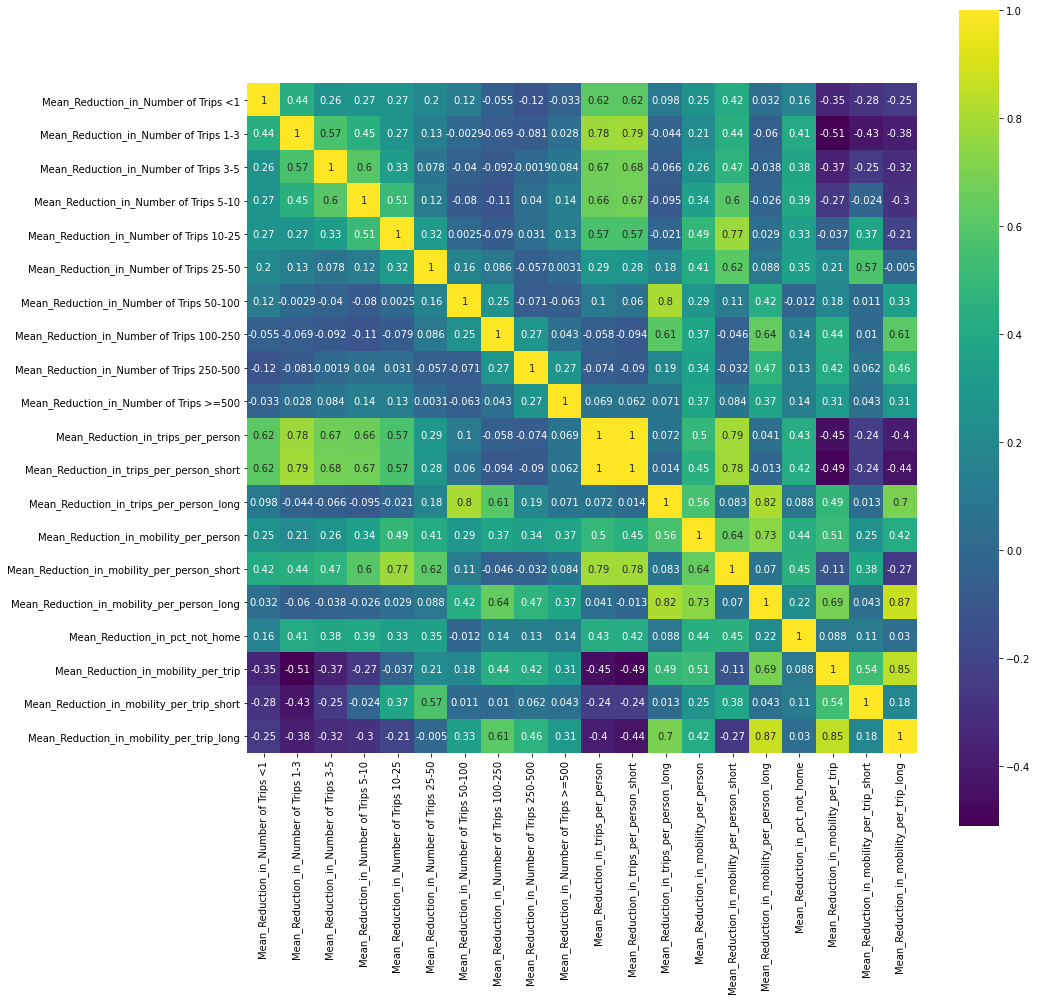

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(df_mob_red.corr(),cmap='viridis',annot=True, square=True,)

In [243]:
pd.set_option('display.max_colwidth', None)

cols = ['target_var','R2_Score','Top 5 Features']
df_model_summary = pd.DataFrame(columns = cols)
for col in df_mob_red.columns[1:]:
    df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=[col], 
                                             task_type='CPU',max_depth = 6,plot=False,print_results=False)
    top_features = list(df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:5].index)
    df_model_ = pd.DataFrame([[col,r2score,top_features]],columns=cols)

    df_model_summary = df_model_summary.append(df_model_,ignore_index=True,)
df_model_summary

,target_var,R2_Score,Top 5 Features
0,Mean_Reduction_in_trips_per_person,0.38,"[STATE, Unemployed_Pct|Aug-20, cs_educ_ba, NumCivLaborForce2009, Days_Mandate quarantine for all individuals entering the state from another state]"
1,Mean_Reduction_in_trips_per_person_short,0.39,"[STATE, Unemployed_Pct|Aug-20, Days_Mandate quarantine for all individuals entering the state from another state, cs_educ_ba, Employed|Dec-19]"
2,Mean_Reduction_in_trips_per_person_long,0.30,"[County_Area in m2 - Land area, Days_SNAP Waiver-Emergency Allotments to Current SNAP Households, County_Area in m2 - Total area, STATE, Travel Time to Work_25 to 29 minutes]"
3,Mean_Reduction_in_mobility_per_person,0.50,"[Employed|May-20, PovertyUnder18Pct, Days_Stay at home/ shelter in place, MedHHInc, NumEmployed2007]"
4,Mean_Reduction_in_mobility_per_person_short,0.39,"[STATE, NumEmployed2007, NumCivLaborForce2008, Days_State of emergency, Employed|Feb-20]"
5,Mean_Reduction_in_mobility_per_person_long,0.34,"[cs_frac_black, Race_Black or African American alone, puninsured2010, Ed1LessThanHSPct, BlackNonHispanicPct2010]"
6,Mean_Reduction_in_pct_not_home,0.57,"[median_house_value, ForeignBornEuropeNum, STATE, MultipleRacePct2010, TotalPopEst2017]"
7,Mean_Reduction_in_mobility_per_trip,0.29,"[NativeAmericanNonHispanicPct2010, MedianNonVetsInc, STATE, Ratio of Income to Poverty Level in the Past 12 Months_2.00 and over, Days_Mandate quarantine for those entering the state from specific states]"
8,Mean_Reduction_in_mobility_per_trip_short,0.20,"[Travel Time to Work_30 to 34 minutes, poor_share, PovertyAllAgesPct, County_Area in m2 - Land area, Travel Time to Work_25 to 29 minutes]"
9,Mean_Reduction_in_mobility_per_trip_long,0.29,"[puninsured2010, Days_SNAP Waiver-Pandemic EBT, cs_frac_black, BlackVetsPct, Travel Time to Work_90 or more minutes]"


In [220]:
df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:10]

,Red_Mob_Covid_Feature_Importance
"Means of Transportation to Work_Car, truck, or van",2.036447
cs_frac_black,1.686119
NumEmployed2015,1.651128
NumEmployed2009,1.637315
puninsured2010,1.478704
median_house_value,1.425218
NumCivLaborForce2012,1.396424
Days_State of emergency,1.195398
County_Area in m2 - Water area,1.173034
hhinc00,1.139876


In [201]:
df_model['Days_State of emergency'].unique()

array([12, 10,  3,  9,  8, 13,  5, 11, 14,  4,  6,  7, -1, 15],
      dtype=int64)